Load a time series of MODIS (MxD11_L2) LST observations from a directory

In [1]:
import xarray as xr
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate
import cartopy.crs as ccrs
import datetime as dt
import gdal

gdal.UseExceptions()

%matplotlib inline

Find all HDF files in a specified directory

In [2]:
def getListOfFiles(dirName,ext):
    '''Create a list of file names in the given directory with specified file extension.'''
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Only match files with the correct extension
        if '.'+ext == os.path.splitext(entry)[1]:
            # Create full path and add to list
            fullPath = os.path.join(dirName, entry)
            allFiles.append(fullPath)       
    return allFiles

In [3]:
storage = r'//j-lundquist-3.ce.washington.edu/storage'

lst_searchDir = storage + r'/MODIS/GrandMesa_MxD11_L2/'
lst_file_list = getListOfFiles(lst_searchDir,'hdf')

geo_searchDir = storage + r'/MODIS/GrandMesa_MxD03/'
geo_file_list = getListOfFiles(geo_searchDir,'hdf')

print('Found {} LST files, {} GEO files'.format(len(lst_file_list),len(geo_file_list)))

Found 90 LST files, 90 GEO files


In [4]:
lst_ds = [gdal.Open('HDF4_EOS:EOS_SWATH:"{}":MOD_Swath_LST:LST'.format(path)) for path in lst_file_list]
viewangle_ds = [gdal.Open('HDF4_EOS:EOS_SWATH:"{}":MOD_Swath_LST:View_angle'.format(path)) for path in lst_file_list]
geo_lat_ds = [gdal.Open('HDF4_SDS:UNKNOWN:"{}":0'.format(path)) for path in geo_file_list]
geo_lon_ds = [gdal.Open('HDF4_SDS:UNKNOWN:"{}":1'.format(path)) for path in geo_file_list]

In [5]:
n_files = len(lst_ds)
m_files = len(geo_lat_ds)
# Because the MODIS products are either 2030 or 2040 pixels in 5 minutes...
# I'm truncating them all to just 2030
along_track_px = 2030
cross_track_px = 1354

# Create empty arrays to hold the radiance, lat, and lon

lst = np.ones((n_files,   # Number of MODIS HDF files
               along_track_px,  # Width
               cross_track_px), # Height
              dtype='float64')

viewangle = np.ones((n_files,   # Number of MODIS HDF files
               along_track_px,  # Width
               cross_track_px), # Height
              dtype='float64')

lon = np.ones((n_files,   # Number of MODIS HDF files
               along_track_px,  # Width
               cross_track_px), # Height
              dtype='float64')

lat = np.ones((n_files,   # Number of MODIS HDF files
               along_track_px,  # Width
               cross_track_px), # Height
              dtype='float64')

In [6]:
# LST scale factor
lst_scale_factor=0.02
# View angle scale factor
view_scale_factor = 0.5
# For each file in the timeseries of MODIS observations
k = 0
for i in range(0,n_files):
    # Read the date and time from the LST product
    date = lst_ds[i].GetMetadataItem('RANGEBEGINNINGDATE')
    time = lst_ds[i].GetMetadataItem('RANGEBEGINNINGTIME')
    eq_cross_time = lst_ds[i].GetMetadataItem('EQUATORCROSSINGTIME.1')
    # Find its matching MxD03 Geolocation product
    for j in range(0,m_files):
        date2 = geo_lat_ds[j].GetMetadataItem('RANGEBEGINNINGDATE')
        time2 = geo_lat_ds[j].GetMetadataItem('RANGEBEGINNINGTIME')
        eq_cross_time2 = geo_lat_ds[j].GetMetadataItem('EQUATORCROSSINGTIME.1')
        # Once we find a match, load these into our arrays
        if eq_cross_time==eq_cross_time2:# and lst_ds[i].ReadAsArray() is not None:
            print('Found files for {} {}'.format(date,time))
            # Load the LST values and scale them
            lst[k] = lst_scale_factor * lst_ds[i].ReadAsArray()[0:along_track_px,0:cross_track_px]
            # Replace the nodata value 0, with Nans
            lst[k][lst[k]==0.] = np.nan
            # Read the view angles from the LST product, scale and remove nodata values
            viewangle[k] = viewangle_ds[i].ReadAsArray()[0:along_track_px,0:cross_track_px]
            viewangle[k][viewangle[k]==255] = np.nan
            viewangle[k] = view_scale_factor * viewangle[k]
            # Read the latitudes and longitudes from the geolocaiton product
            lat[k] = geo_lat_ds[j].ReadAsArray()[0:along_track_px,0:cross_track_px]
            lon[k] = geo_lon_ds[j].ReadAsArray()[0:along_track_px,0:cross_track_px]
            # Add the MODIS data to an xarray dataset
            if k==0: # If this is our first file, make a new dataset
                ds = xr.Dataset({'lst': (['line', 'pixel'],  lst[k]),
                                'viewangle': (['line', 'pixel'],  viewangle[k])},
                                coords={'longitude': (['line', 'pixel'], lon[k]),
                                        'latitude': (['line', 'pixel'], lat[k]),
                                        'time': pd.to_datetime('{} {}'.format(date,time))})
                k+=1 # add to the successful file load counter
            else: # append to existing dataset
                ds_new = xr.Dataset({'lst': (['line', 'pixel'],  lst[k]),
                                'viewangle': (['line', 'pixel'],  viewangle[k])},
                                coords={'longitude': (['line', 'pixel'], lon[k]),
                                        'latitude': (['line', 'pixel'], lat[k]),
                                        'time': pd.to_datetime('{} {}'.format(date,time))})
                ds = xr.concat([ds,ds_new],'time')
                k+=1 # add to the successful file load counter

# Finally sort by time:
ds = ds.sortby(ds.time)
print('{} out of {} files loaded with geolocation information'.format(k,n_files))

# Update to the number of many files did we successfully loaded?
n_files = ds.time.shape[0]


Found files for 2017-02-10 05:45:00.000000
Found files for 2017-02-10 17:45:00.000000
Found files for 2017-02-11 04:50:00.000000
Found files for 2017-02-11 18:30:00.000000
Found files for 2017-02-12 05:35:00.000000
Found files for 2017-02-12 17:35:00.000000
Found files for 2017-02-13 04:40:00.000000
Found files for 2017-02-13 18:15:00.000000
Found files for 2017-02-14 05:20:00.000000
Found files for 2017-02-14 17:20:00.000000
Found files for 2017-02-14 19:00:00.000000
Found files for 2017-02-15 04:25:00.000000
Found files for 2017-02-15 06:05:00.000000
Found files for 2017-02-15 18:05:00.000000
Found files for 2017-02-16 05:10:00.000000
Found files for 2017-02-16 18:50:00.000000
Found files for 2017-02-17 05:50:00.000000
Found files for 2017-02-17 17:55:00.000000
Found files for 2017-02-18 04:55:00.000000
Found files for 2017-02-18 18:35:00.000000
Found files for 2017-02-19 05:40:00.000000
Found files for 2017-02-19 17:40:00.000000
Found files for 2017-02-20 04:45:00.000000
Found files

TypeError: 'NoneType' object is not subscriptable

In [25]:
geo_lon_ds[30]

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000025435A61A80> >

Plot and save each MODIS timestep figure

In [27]:
for t in range(ds.time.shape[0]):
    ds.lst[t].plot(x='longitude',y='latitude',cmap='magma',vmin=250,vmax=350)
    plt.xlim((-110,-106))
    plt.ylim((37,41))
    plt.savefig('{}_GrandMesa_MxD11_L2_LST.png'.format(str(ds.time[t].values)[0:13]),dpi=300)
    plt.close('all')

Get the MODIS pixel coordinates for our ground based observations from each observation

In [28]:
# approx locaiton of Gaylor Pit
#lat_obs = 37.88 
#long_obs=-119.31

# approx locaiton of Mesa West
lat_obs = 39.0338
long_obs=-108.214

# approx locaiton of Mesa Middle
#lat_obs = 39.0396
#long_obs=-107.9417

# approx locaiton of LSOS
#lat_obs = 39.0522
#long_obs=-108.0979

Find coordinates corresponding to this location at each timestep of MODIS observations

In [29]:
coordinates = [np.unravel_index((np.abs(ds.latitude[time] - lat_obs) 
                                + np.abs(ds.longitude[time] - long_obs)).argmin(), 
                               ds.latitude[time].shape)
               for time in range(0,len(ds.time))]

In [35]:
temp=[]
datetime=[]
viewtime=[]
viewangle=[]
temp_mean=[]
temp_min=[]
temp_max=[]
# Make a separate array of pixels around our point of interest
m = 1 # for a 3x3 grid, m=1
b=0.5 #bounds, +/- in degrees lat/lon
n=0
for t in range(0,len(coordinates)):
    # Find LST value at the specified coordinates
    temp.append(ds.lst[t][coordinates[t]].values - 273.15)
    #try: # trying to get a grid of pixel values around Gaylor Pit
    #    temp_grid = ds.lst[t][coordinates[t][0]-m:coordinates[t][0]+1+m,coordinates[t][1]-m:coordinates[t][1]+1+m].values
    #    print(temp_grid)
    #    temp_mean.append(np.nanmean(temp_grid) - 273.15)
    #    temp_min.append(np.nanmin(temp_grid) - 273.15)
    #    temp_max.append(np.nanmax(temp_grid) - 273.15)
    #except ValueError:
    #    nan_placeholder = np.ones((3,3))*np.nan
    #    temp_mean.append(nan_placeholder)
    #    temp_min.append(nan_placeholder)
    #    temp_max.append(nan_placeholder)

    
    # Find the date and time of this observation
    datetime.append(pd.to_datetime(ds.time[t].values))
    
    # Record view time and view angle of this point
    #viewtime.append(f.View_time[coordinates].values)
    viewangle.append(ds.viewangle[t][coordinates[t]].values)
    
    # print and save figure
    fig, ax = plt.subplots(figsize=(7,7))
    ax = plt.axes(projection=ccrs.Orthographic(-117, 39))
    ds.lst[t].plot.pcolormesh('longitude', 'latitude',cmap='magma',
                          vmin=250, vmax=350, ax=ax, transform=ccrs.PlateCarree(),zorder=30);
    #ax.set_global(); #ax.stock_img();
    ax.coastlines();
    ax.gridlines();
    ax.set_extent([long_obs-b,long_obs+b, lat_obs-b,lat_obs+b], crs=ccrs.PlateCarree())
    ax.set_title('MODIS LST {}'.format(datetime[n]))
    plt.savefig('MODIS LST {}.png'.format(n))
    plt.close('all')
    n+=1

d = {'datetime': datetime, 
     'temperature': temp, 
     #'viewtime': viewtime, 
     'viewangle': viewangle
     #'temp_min': temp_min,
     #'temp_max': temp_max,
     #'temp_mean': temp_mean
     }
modis = pd.DataFrame(data=d)
modis['datetime'] +=  pd.to_timedelta(-7, unit='h')
modis = modis.sort_values('datetime').reset_index()

In [36]:
modis

,index,datetime,temperature,viewangle
0,0,2017-02-09 22:45:00,NaN,nan
1,1,2017-02-10 10:45:00,NaN,nan
2,2,2017-02-10 21:50:00,NaN,nan
3,3,2017-02-11 11:30:00,NaN,nan
4,4,2017-02-11 22:35:00,NaN,nan
5,5,2017-02-12 10:35:00,NaN,nan
6,6,2017-02-12 21:40:00,NaN,nan
7,7,2017-02-13 11:15:00,NaN,nan
8,8,2017-02-13 22:20:00,NaN,nan
9,9,2017-02-14 10:20:00,-1.09,60.0


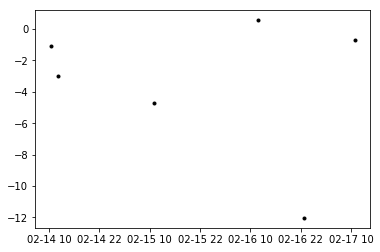

In [37]:
plt.plot(modis.datetime,modis.temperature,'.k')

Load Gaylor Pit snow surface temperature data

In [25]:
# Gaylor Pit surface temperature data
filepath = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\GaylorPit\GaylorPit2017_039_T15min.csv'
gaylor = pd.read_csv(filepath)

# Make some data type and unit conversions
gaylor['datetime'] = pd.to_datetime(gaylor['TIMESTAMP']) # timestamp string to pandas datetime
gaylor['Judd_Air_TempC'] = (gaylor['Judd_Air_TempF'] - 32) / 1.8 # temperature F to temperature C
gaylor['Judd_Depth_cm'] = gaylor['Judd_Depth_in'] * 2.54 # snowdepth inches to snowdepth cm


Plot MODIS LST and Gaylor Pit temperature data together

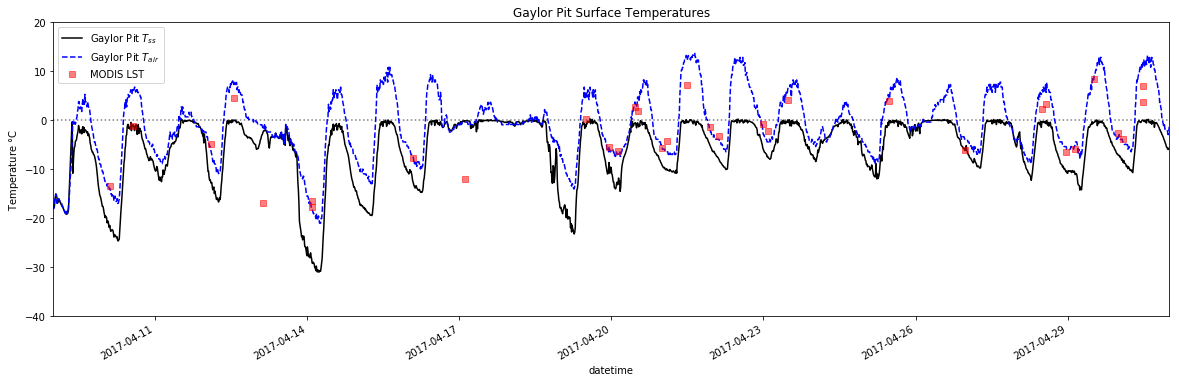

In [85]:
starttime = pd.to_datetime('2017-04-09 00:00')
endtime = pd.to_datetime('2017-04-30 23:59:59')

fig, ax = plt.subplots(figsize=(20,6))

plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')

gaylor.plot(x='datetime',y='TT_C', color='k', ax=ax, label= 'Gaylor Pit $T_{ss}$')
gaylor.plot(x='datetime',y='Judd_Air_TempC', linestyle='--', color='b', ax=ax, label= 'Gaylor Pit $T_{air}$')
modis.plot(x='datetime',y='temperature',
           marker='s',c='r',linestyle='None',ax=ax,
           label='MODIS LST',alpha=0.5)
#plt.errorbar(modis.datetime,modis.temp_mean,
#             yerr=np.array((modis.temp_max-modis.temp_min)/2),
#             linestyle='None',c='r',linewidth=1.5,
#             label='{}x{} MODIS LST Range'.format((m*2)+1,(m*2)+1))
#
plt.legend()
ax.set_xlim((starttime,endtime))
ax.set_ylim((-40,20))
ax.set_ylabel('Temperature $\degree$C');
ax.set_title('Gaylor Pit Surface Temperatures');
#plt.savefig('GaylorPit-MODIS-LST-timeline.png',dpi=300)

Find the Gaylor Pit observations closest in time to our MODIS data, compute the difference between MODIS LST and Gaylor Pit Tsnow and Tair

In [52]:
def nearest(items, pivot):
    #https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

In [53]:
# Compute the difference in temperatures (Gaylor Pit - MODIS)
delta_tair = []
delta_tsnow = []
gaylor_tair = []
gaylor_tsnow = []

i = 0
for time in modis['datetime']:
    gaylor_time = (nearest(gaylor['datetime'],time))
    #print('MODIS Time:{} \t Gaylor Time:{}'.format(time,gaylor_time))
    gaylor_tsnow.append(gaylor['TT_C'][gaylor['datetime']==gaylor_time].values[0])
    gaylor_tair.append(gaylor['Judd_Air_TempC'][gaylor['datetime']==gaylor_time].values[0])
    modis_t = modis.temperature[modis['datetime']==time].values[0]
    #modis_tmin = modis.temp_min[modis['datetime']==time].values[0]
    #modis_tmax = modis.temp_max[modis['datetime']==time].values[0]
    #print('{} \t {} \t {}'.format(modis_t,gaylor_tsnow,gaylor_tair))
    delta_tsnow.append(modis_t - gaylor_tsnow[i])
    delta_tair.append(modis_t - gaylor_tair[i])
    i+=1


Plot MODIS LST vs Gaylor Pit Tsnow and Tair to see how they compare...

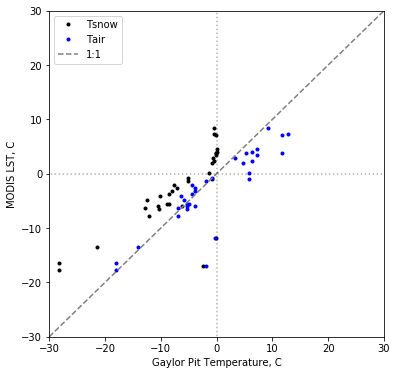

In [138]:
plt.figure(figsize=(6,6))
plt.plot(gaylor_tsnow,modis.temperature,'.k',label='Tsnow')
plt.plot(gaylor_tair,modis.temperature,'.b',label='Tair')
plt.plot([-30,30],[-30,30],'--',c='tab:grey',label='1:1')
plt.plot([0,0],[-100,100],':',c='k',alpha=0.3)
plt.plot([-100,100],[0,0],':',c='k',alpha=0.3)
#plt.text(10,-30,'MODIS colder')
#plt.text(-30,19,'MODIS warmer')
plt.xlabel('Gaylor Pit Temperature, C')
plt.ylabel('MODIS LST, C')
plt.xlim((-30,30))
plt.ylim((-30,30))
plt.legend()
#plt.savefig('GaylorPit-vs-MODIS-LST.png',dpi=300)

How does the difference between MODIS LST and ground data change as a function of time?

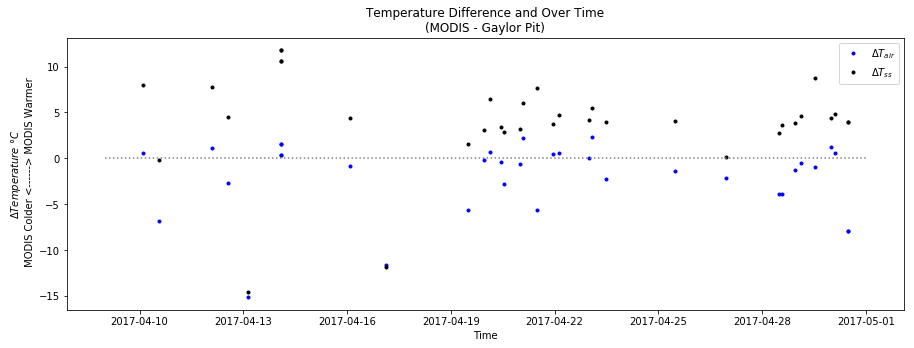

In [81]:
plt.figure(figsize=(15,5))
plt.plot(modis.datetime,delta_tair,'.b',label='$\Delta T_{air}$',alpha=1);
plt.plot(modis.datetime,delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('Time')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')
plt.title('Temperature Difference and Over Time\n(MODIS - Gaylor Pit)');

#plt.savefig('GaylorPit-MODIS-deltaLST-timeline.png',dpi=300)

How does the difference between MODIS LST and ground data change as a function of hour of day?

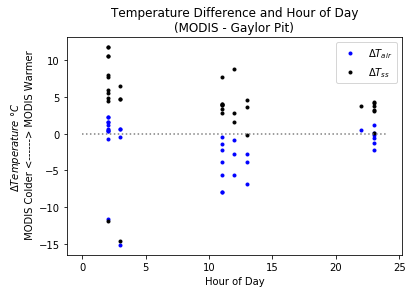

In [82]:
plt.plot(pd.DatetimeIndex(modis.datetime).hour,delta_tair,'.b',label='$\Delta T_{air}$',alpha=1);
plt.plot(pd.DatetimeIndex(modis.datetime).hour,delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('Hour of Day')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.plot([0, 24],[0, 0],':',c='tab:grey')
plt.title('Temperature Difference and Hour of Day\n(MODIS - Gaylor Pit)');

#plt.savefig('GaylorPit-MODIS-deltaLST-hour-of-day.png',dpi=300)

How does the difference between MODIS LST and ground data change as a function of view angle?

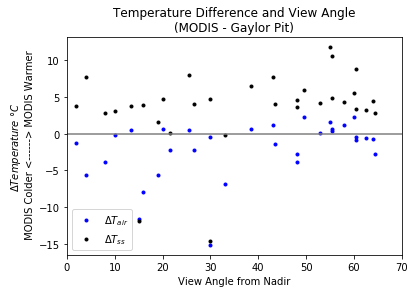

In [83]:
plt.plot(modis.viewangle,delta_tair,'.b',label='$\Delta T_{air}$',alpha=1);
plt.plot(modis['viewangle'],delta_tsnow,'.k',label='$\Delta T_{ss}$',alpha=1);

plt.xlabel('View Angle from Nadir')
plt.ylabel('$\Delta Temperature \,\, \degree C$\n MODIS Colder <------> MODIS Warmer')
plt.legend()
plt.xlim([0,70])
plt.plot([0, 70],[0, 0],'-',c='tab:grey')
plt.title('Temperature Difference and View Angle\n(MODIS - Gaylor Pit)');

#plt.savefig('GaylorPit-MODIS-deltaLST-view-angle.png',dpi=300)

If we assume a weighted mean between tforest (guessing that it can be represented here by tair) and tsnow, figure out what those weights are here.

In other words:

MODIS LST = ( (1-n) * Tforest + n * Tsnow )

where 1-n is the forest fraction of the pixel, and n is the snow fraction of the pixel

Therefore solving for n:

n = (MODIS LST - Tforest) / (Tsnow - Tforest)

In [44]:
snow_fraction = []
for i in range(0,len(modis.temperature)):
    snow_fraction.append(( modis.temperature[i] - gaylor_tair[i] ) / (gaylor_tsnow[i] - gaylor_tair[i]))


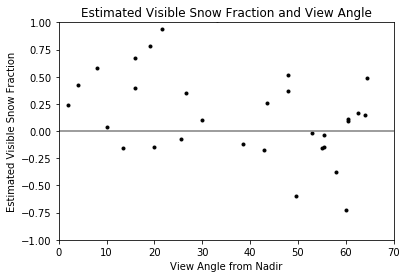

In [84]:
plt.plot(modis['viewangle'],snow_fraction,'.k');
plt.xlabel('View Angle from Nadir')
plt.ylabel('Estimated Visible Snow Fraction')
plt.xlim([0,70])
plt.ylim([-1,1])
plt.plot([0, 70],[0, 0],'-',c='tab:grey')
plt.title('Estimated Visible Snow Fraction and View Angle');

# Where snow fraction is < 0, MODIS LST is higher than Tair

#plt.savefig('GaylorPit-MODIS-fsca-test.png',dpi=300)

***
***

What's the spread between Tsnow and Tair over time?

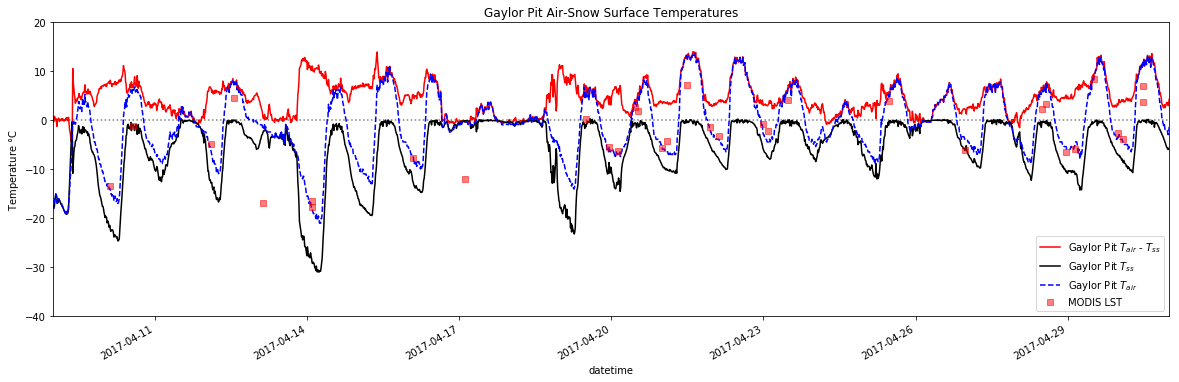

In [137]:
starttime = pd.to_datetime('2017-04-09 00:00')
endtime = pd.to_datetime('2017-04-30 23:59:59')

fig, ax = plt.subplots(figsize=(20,6))

plt.plot([starttime, endtime],[0, 0],':',c='tab:grey')

plt.plot(gaylor.datetime,gaylor.Judd_Air_TempC-gaylor.TT_C, color='r', label= 'Gaylor Pit $T_{air}$ - $T_{ss}$')
gaylor.plot(x='datetime',y='TT_C', color='k', ax=ax, label= 'Gaylor Pit $T_{ss}$')
gaylor.plot(x='datetime',y='Judd_Air_TempC', linestyle='--', color='b', ax=ax, label= 'Gaylor Pit $T_{air}$')
modis.plot(x='datetime',y='temperature',
           marker='s',c='r',linestyle='None',ax=ax,
           label='MODIS LST',alpha=0.5)
plt.legend()
ax.set_xlim((starttime,endtime))
ax.set_ylim((-40,20))
ax.set_ylabel('Temperature $\degree$C');
ax.set_title('Gaylor Pit Air-Snow Surface Temperatures');
plt.savefig('Gaylor Pit Air-Snow Surface Temperatures.png',dpi=300)

***
***

In [4]:
## Just do some quick plotting to make sure I'm looking at the right timestamps ...
## ...in the metadata and everyting lines up as I'd hope
#
#plt.figure(figsize=(19,10))
#img_extent = (-124, -115, 33, 40)
#ax = plt.axes(extent=img_extent,projection=ccrs.PlateCarree())
#ax.coastlines(resolution='10m', color='white', linewidth=1)
#
#max_color_lst = 350 #np.mean(ds.lst) + 2*np.std(ds.lst)
#min_color_lst = 250 #np.min(ds.lst) # min
#    
#for t in range(0,n_files):
#    cbar_flag = True if t == 0 else False
#    ds.lst[t].plot.pcolormesh(x='longitude',y='latitude', 
#               ax=ax,vmin=min_color_lst, vmax=max_color_lst, 
#               cmap='magma', add_colorbar=cbar_flag, transform=ccrs.PlateCarree(),
#               robust=True, subplot_kws={'projection':ccrs.PlateCarree()})
#
#    plt.plot(ds.longitude[t,coordinates[t][0],coordinates[t][1]],
#             ds.latitude[t,coordinates[t][0],coordinates[t][1]],
#             'xw')
#
#plt.show()
#